In [4]:
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

from PIL import Image
import cv2
from skimage import io
import os

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import mobilenet_v2, resnet50

### I. Import des modèles et des données

#### 1. Import du DataFrame contenant les chemins des images de la base de données

In [5]:
df = pd.read_csv(Path("V2_Plant_Seedlings_DataFrame.csv"))
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,sharpness_score,image_size,square
0,Input\Maize\196.png,Maize,196.png,1260,1260,96.623133,95.263001,68.305443,86.730526,371.683979,1587600,square
1,Input\Cleavers\33.png,Cleavers,33.png,352,352,80.315397,70.118769,50.518635,66.984267,39.836262,123904,square
2,Input\Charlock\454.png,Charlock,454.png,990,990,80.529463,75.808330,55.868748,70.735514,305.574312,980100,square
3,Input\Small-flowered Cranesbill\5.png,Small-flowered Cranesbill,5.png,162,162,80.199131,71.348765,45.413733,65.653876,9.546821,26244,square
4,Input\Small-flowered Cranesbill\91.png,Small-flowered Cranesbill,91.png,323,323,83.221012,71.454773,45.279941,66.651909,31.808805,104329,square


In [6]:
# Mapping des labels
label2classes = {0: 'Black-grass',
                 1: 'Charlock',
                 2: 'Cleavers',
                 3: 'Common Chickweed',
                 4: 'Common wheat',
                 5: 'Fat Hen',
                 6: 'Loose Silky-bent',
                 7: 'Maize',
                 8: 'Scentless Mayweed',
                 9: "Shepherd's Purse",
                 10: 'Small-flowered Cranesbill',
                 11: 'Sugar beet'}

#### 2. Import des modèles à tester, définition des fonctions de preprocessing et de prédiction

In [7]:
# Modèle MobileNetV2 optimisé: avec augmentation faible + segmentation

mobilenet_filepath = Path("mobilenetV2_lowaugm_segmentation_finalmodel")
mobilenet = load_model(mobilenet_filepath)

In [9]:
# Modèle ResNet50 optimisé: avec augmentation faible + segmentation

resnet_filepath = Path("resnet50_lowaugm_segmentation_finalmodel")
resnet = load_model(resnet_filepath)
resnet.compile('adam','sparse_categorical_accuracy','accuracy')

In [10]:
# Modèle VGG19: avec augmentation forte, sans segmentation

vgg19_filepath = Path("vgg19_strongaugm_nosegmentation_finalmodel","VGG19_9507.h5")
vgg19 = load_model(vgg19_filepath,compile=False)
vgg19.compile('adam','sparse_categorical_accuracy','accuracy')

In [11]:
# Fonction de segmentation par seuillage

def threshold_segmentation(input_img):
    
    threshold=118
    img_rgb = np.uint8(input_img)
    img_rgb = cv2.resize(img_rgb,(224,224))
    img_lab = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2LAB)
    
    # Création du masque par seuillage
    _,mask = cv2.threshold(img_lab[:,:,1],threshold,255,cv2.THRESH_BINARY_INV)
    
     # Elimination du bruit par ouverture puis fermeture
    kernel = np.ones((2,2))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Application du masque à l'image
    masked_img = cv2.bitwise_and(img_rgb,img_rgb,mask=mask)
    
    return masked_img

In [12]:
# Fonctions de pre-processing incluant la segmentation par seuillage pour les modèles MobileNetV2 et ResNet50

def mobilenet_preprocessing_with_tsegm(input_img):
    
    # Etape 1: Segmentation simple par seuillage
    masked_img = threshold_segmentation(input_img)

    # Etape 2: Pre-processing propre à MobileNetV2 (normalisation dans l'intervalle [-1,1]))
    final_input = mobilenet_v2.preprocess_input(masked_img)
    
    return final_input    

def resnet_preprocessing_with_tsegm(input_img):
    
    # Etape 1: Segmentation simple par seuillage
    masked_img = threshold_segmentation(input_img)

    # Etape 2: Pre-processing propre à ResNet50 (normalisation dans l'intervalle [-1,1]))
    final_input = resnet50.preprocess_input(masked_img)
    
    return final_input    


In [53]:
# Fonctions de pre-procesing + prédiction des différents modèles

def mobilenet_preprocess_and_predict(img_filepath):
    
    """
    Fonction réalisant le pre-processing d'une image avec segmentation par seuillage, puis la classification 
    par le modèle MobileNetV2, et renvoyant les probabilités des différentes classes
    Argument:
    img_filepath: str: chemin d'accès à l'image
    """
    
    # Pre-processing
    img = load_img(img_filepath,target_size=(224,224))
    segmented_img = mobilenet_preprocessing_with_tsegm(img)
    input_arr = np.array([segmented_img])  # Convert single image to a batch.
    
    # Prédiction
    pred = np.squeeze(mobilenet.predict(input_arr,verbose=0))
        
    return pred

def resnet_preprocess_and_predict(img_filepath):
    
    """
    Fonction réalisant le pre-processing d'une image avec segmentation par seuillage, puis la classification 
    par le modèle ResNet50, et renvoyant les probabilités des différentes classes
    Argument:
    img_filepath: str: chemin d'accès à l'image
    """
    
    # Pre-processing
    img = load_img(img_filepath,target_size=(224,224))
    segmented_img = resnet_preprocessing_with_tsegm(img)
    input_arr = np.array([segmented_img])  # Convert single image to a batch.
    
    # Prédiction
    pred = np.squeeze(resnet.predict(input_arr,verbose=0))
        
    return pred

def vgg19_preprocess_and_predict(img_filepath):
    
    """
    Fonction réalisant le pre-processing d'une image (sans segmentation), puis la classification 
    par le modèle VGG19, et renvoyant les probabilités des différentes classes
    Argument:
    img_filepath: str: chemin d'accès à l'image
    """
    
    # Pre-processing
    img = load_img(img_filepath,target_size=(224,224))
    img = img_to_array(img)/255.
    input_arr = np.array([img])  # Convert single image to a batch.
    
    # Prédiction
    pred = np.squeeze(vgg19.predict(input_arr,verbose=0))
        
    return pred

### II. Segmentation par seuillage: vérification de la consistance des prédictions avec pre-processing manuel et par ImageDataGenerator (modèle MobileNetV2)

#### 1. Fonction de prédiction sur une image pre-processée par ImageDataGenerator

In [14]:
def mobilenet_datagen_and_predict(img_filepath):
    
    """
    Fonction réalisant le pre-processing d'une image de la base de données par ImageDataGenerator (avec segmentation par 
    seuillage),puis la classification par le modèle MobileNetV2, et renvoyant les probabilités des différentes classes
    Argument:
    img_filepath: str: chemin d'accès à l'image (image de la base de données uniquement!)
    
    """

    # Pre-processing
    data_generator = ImageDataGenerator(preprocessing_function=mobilenet_preprocessing_with_tsegm)
    data_iterator = data_generator.flow_from_dataframe(df[df['filepath']==img_filepath],
                                                       x_col='filepath',
                                                       y_col='species',
                                                       target_size=(224,224),
                                                       class_mode='sparse',
                                                       batch_size=1)

    # Prédiction
    pred = np.squeeze(mobilenet.predict(data_iterator,verbose=0))
    
    return pred

#### 2. Comparaison des prédictions sur une image tirée aléatoirement

In [15]:
def show_image(img_filepath,ext=False,label=None):
    
    """
    Fonction affichant une image (externe ou appartenant au jeu de données), ainsi que le label associé si disponible
    Argument:
    img_filepath: str: chemin d'accès à l'image
    ext: bool: False pour une image de la base de données, True pour une image externe à la base
    label: str: Classe de l'image (à préciser uniquement si ext=True)    
    """

    # Récupération du label pour une image du jeu de données
    if ext==False:
        label = Path(img_filepath).parts[-2]
    
    plt.figure(figsize=(3,3))
    img = plt.imread(img_filepath)
    plt.imshow(img)
    if label != None:
        plt.title("Label: "+label,fontsize=10)
    plt.axis('off')   

Index de l'image à prédire: 1447 



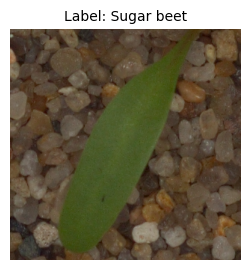

In [22]:
# Choix aléatoire d'une image du jeu de données et affichage

idx = np.random.randint(len(df))
print("Index de l'image à prédire:", idx,"\n")
filepath = df['filepath'][idx]

show_image(filepath)

In [23]:
# Affichage des prédictions avec les différents pre-processings

index = ["Classe réelle","Prédiction (pre-processing par ImageDataGenerator)","Prédiction (pre-processing manuel)"]
classes = [df['species'][idx],
           label2classes[mobilenet_datagen_and_predict(filepath).argmax(axis=-1)],
           label2classes[mobilenet_preprocess_and_predict(filepath).argmax(axis=-1)]]
pd.DataFrame(classes,index=index,columns=['Classe'])

Found 1 validated image filenames belonging to 1 classes.


,Classe
Classe réelle,Sugar beet
Prédiction (pre-processing par ImageDataGenerator),Sugar beet
Prédiction (pre-processing manuel),Sugar beet


#### Test sur un échantillon de N images tirées aléatoirement de la base de données

In [140]:
N_sample = 500
df_sample = df.sample(n=N_sample)

# Prédiction avec pre-processing par ImageDataGenerator
datagen_pred = pd.Series(df_sample.filepath).apply(lambda f: mobilenet_datagen_and_predict(f).argmax(axis=-1))

# Prediction avec pre-processing manuel
manualpreprocess_pred = pd.Series(df_sample.filepath).apply(lambda f: mobilenet_preprocess_and_predict(f).argmax(axis=-1))

Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 valida

Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 valida

Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 valida

Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 valida

In [75]:
# Test: égalité des prédictions?
print("Les prédictions sont-elles identiques avec les deux types de pre-processing?",manualpreprocess_pred.equals(datagen_pred))

Les prédictions sont-elles identiques avec les deux types de pre-processing? True


### III. Comparaison des prédictions du modèle MobileNetV2 en fonction de la méthode de segmentation: seuillage ou Deep Learning

#### 1. Pre-processing avec segmentation par le modèle Unet

In [24]:
# Import du modèle de segmentation par Deep Learning (Unet)

unet_filepath = Path("unet","Unet.h5")
unet = load_model(unet_filepath,compile=False)
unet.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ['SparseCategoricalAccuracy'])

In [25]:
# Fonction de segmentation par le modèle unet

def unet_segmentation(input_img):
    unet_pred = unet.predict(np.array([input_img]),verbose=0).argmax(-1)   # Shape (1,224,224)
    mask = np.squeeze(unet_pred).astype('int8')                            # Shape (224,224)
    img = input_img.astype('int32')
    masked_img = cv2.bitwise_and(img,img,mask=mask)
    return masked_img

In [26]:
# Fonction de pre-processing incluant la segmentation par le modèle Unet

def mobilenet_preprocessing_with_unetsegm(input_img):
    
    # Etape 1: Segmentation par Unet
    masked_img = unet_segmentation(input_img)
    
    # Etape 2: Pre-processing propre à MobileNetV2 (normalisation dans l'intervalle [-1,1]))
    final_input = mobilenet_v2.preprocess_input(masked_img)
    
    return final_input


#### 2. Comparaison des résultats de segmentation pour une image tirée aléatoirement

In [27]:
def show_segmented(img_filepath,ext=False,label=None):
    
    """
    Fonction affichant pour une image donnée l'image originale, l'image segmentée par seuillage et l'image segmentée par Unet
    Argument:
    img_filepath: str: chemin d'accès à l'image
    ext: bool: False pour une image de la base de données, True pour une image externe à la base
    label: str: Classe de l'image (à préciser uniquement si ext=True)
    
    """
    
    path = Path(img_filepath)
    img = load_img(img_filepath,target_size=(224,224))
    input_img = img_to_array(img)

    plt.figure(figsize=(8,3))
    
    if ext == True:
        suptitle = label
    else:
        suptitle = path.parts[-2]+"-"+path.stem
    plt.suptitle(suptitle,fontsize=13,y=0.95)

    plt.subplot(131)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(threshold_segmentation(input_img))
    plt.title("Segmentation par seuillage")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(unet_segmentation(input_img))
    plt.title("Segmentation par Unet")
    plt.axis('off');

Index de l'image à prédire: 2301


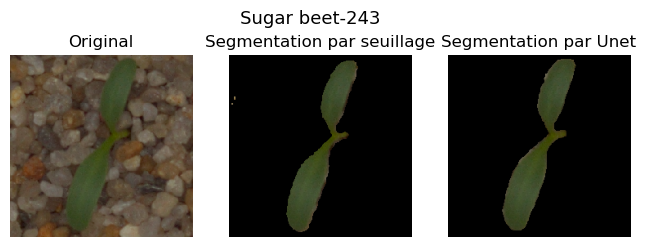

In [80]:
idx = np.random.randint(len(df))
print("Index de l'image à prédire:", idx)
show_segmented(df['filepath'][idx])

#### 3. Prédiction sur une image segmentée par Unet

In [28]:
def mobilenet_unet_preprocess_and_predict(img_filepath):
    
    """
    Fonction réalisant le pre-processing d'une image avec segmentation par Unet, puis la classification 
    par le modèle MobileNetV2
    Argument:
    img_filepath: str: chemin d'accès à l'image
    
    """
   
    # Pre-processing
    img = load_img(img_filepath,target_size=(224,224))
    img = img_to_array(img)                # Conversion de l'image (format PIL Image) en array
    
    segmented_img = mobilenet_preprocessing_with_unetsegm(img)
    input_arr = np.array([segmented_img])  # Convert single image to a batch.

    # Prédiction
    pred = np.squeeze(mobilenet.predict(input_arr,verbose=0))
    
    return pred

#### Comparaison des prédictions sur les images segmentées par seuillage et par Unet

Index de l'image à prédire: 2731 



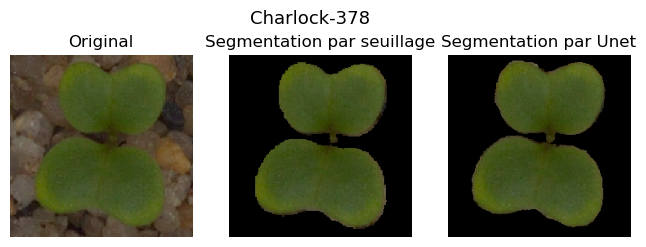

In [31]:
idx = np.random.randint(len(df))
print("Index de l'image à prédire:", idx,"\n")
filepath = df['filepath'][idx]

# Affichage des images segmentées
show_segmented(filepath)


In [32]:
# Comparaison des prédictions
index = ["Réelle","Prédite sur l'image segmentée par seuillage","Prédite sur l'image segmentée par Unet"]
classes = [df['species'][idx],
           label2classes[mobilenet_preprocess_and_predict(filepath).argmax(axis=-1)],
           label2classes[mobilenet_unet_preprocess_and_predict(filepath).argmax(axis=-1)]]
pd.DataFrame(classes, index=index, columns=['Classe'])

,Classe
Réelle,Charlock
Prédite sur l'image segmentée par seuillage,Charlock
Prédite sur l'image segmentée par Unet,Charlock


#### Test sur un échantillon de N images tirées aléatoirement de la base de données

In [86]:
N_sample = 100
df_sample = df.sample(n=N_sample)

compare_pred = df_sample[['filepath']].copy()
# Prediction sur l'image segmentée par seuillage
compare_pred['Threshold segmentation'] = pd.Series(df_sample.filepath).apply(lambda f: mobilenet_preprocess_and_predict(f).argmax(axis=-1))

# Prediction sur l'image segmentée par Unet
compare_pred['Unet segmentation'] = pd.Series(df_sample.filepath).apply(lambda f: mobilenet_unet_preprocess_and_predict(f).argmax(axis=-1))

In [87]:
compare_pred.head()

,filepath,Threshold segmentation,Unet segmentation
1150,Input\Charlock\401.png,1,1
1048,Input\Sugar beet\418.png,11,11
3354,Input\Black-grass\112.png,0,0
4117,Input\Loose Silky-bent\329.png,6,6
228,Input\Maize\76.png,7,7


In [88]:
# Test: égalité des prédictions?
print("Les prédictions sont-elles identiques avec les deux types de pre-processing?",
      compare_pred['Threshold segmentation'].equals(compare_pred['Unet segmentation']))

Les prédictions sont-elles identiques avec les deux types de pre-processing? False


In [89]:
# Analyse des images de l'échantillon prédites différemment suivant le mode de segmentation

diff_pred = compare_pred[compare_pred['Threshold segmentation']!=compare_pred['Unet segmentation']]
display(diff_pred)
print("Nombre d'images prédites différemment suivant le mode de segmentation:",len(diff_pred))

,filepath,Threshold segmentation,Unet segmentation
2377,Input\Black-grass\334.png,4,0
3233,Input\Loose Silky-bent\345.png,6,0
3699,Input\Loose Silky-bent\53.png,6,8
1492,Input\Common wheat\197.png,4,2
1500,Input\Loose Silky-bent\604-13.png,6,0
3024,Input\Loose Silky-bent\604-1.png,6,0


Nombre d'images prédites différemment suivant le mode de segmentation: 6


In [33]:
def show_segmented_and_pred(img_filepath,ext=False,label=None):
    
    """
    Fonction affichant pour une image donnée:
    - l'image originale et son label, 
    - l'image segmentée par seuillage et sa prédiction par MobileNetV2,
    - l'image segmentée par Unet et sa prédiction par MobileNetV2.
    Arguments:
    img_filepath: str: chemin d'accès à l'image
    ext: bool: False pour une image de la base de données, True pour une image externe à la base
    label: str: Classe de l'image (à préciser uniquement si ext=True)    
    """
    
    img = load_img(img_filepath,target_size=(224,224))
    input_img = img_to_array(img)

    plt.figure(figsize=(8,3))
    
    plt.subplot(131)
    plt.imshow(img)
    if ext==False:
        label = Path(img_filepath).parts[-2]        
    if label != None:
        plt.title("Original\n Label: "+label,fontsize=10)
    else:
        plt.title("Original",fontsize=10)
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(threshold_segmentation(input_img))
    pred = mobilenet_preprocess_and_predict(img_filepath).argmax(axis=-1)
    prob = mobilenet_preprocess_and_predict(img_filepath)[pred]
    title = "Segmentation par seuillage\n {} ({:.2%})".format(label2classes[pred],prob)
    plt.title(title,fontsize=10)
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(unet_segmentation(input_img))
    pred = mobilenet_unet_preprocess_and_predict(img_filepath).argmax(axis=-1)
    prob = mobilenet_unet_preprocess_and_predict(img_filepath)[pred]
    title = "Segmentation par Unet\n {} ({:.2%})".format(label2classes[pred],prob)
    plt.title(title,fontsize=10)
    plt.axis('off');

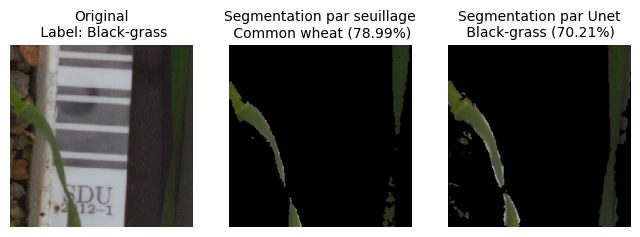

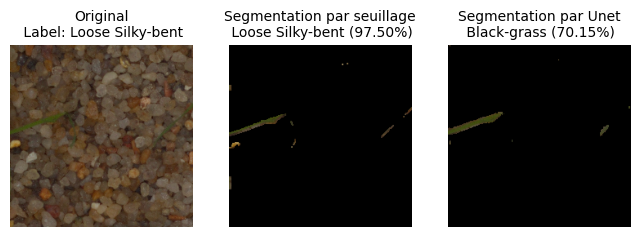

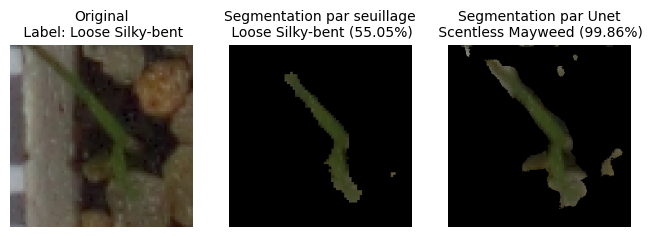

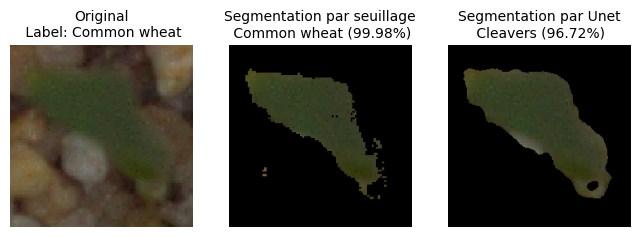

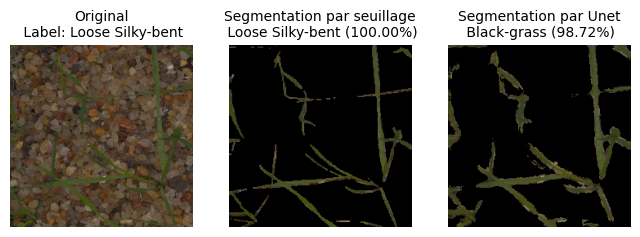

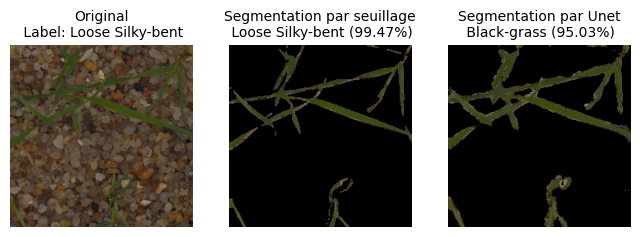

In [91]:
for f in diff_pred['filepath']:
    show_segmented_and_pred(f)

### IV. Comparaison des prédictions des modèles VGG19, MobileNetV2, ResNet50

In [54]:
def show_model_pred(img_filepath,model='MobileNetV2'):
    
    """
    Fonction affichant pour une image et un modèle donnés les 3 classes les plus probables prédites par le modèle.
    Arguments:
    img_filepath: str: chemin d'accès à l'image
    model: str: Modèle CNN utilisé pour la prédiction: au choix MobileNetV2', 'VGG19', 'ResNet50' ou 'all' pour comparer les 
                3 modèles
    """
    
    # Définition d'une fonction retournant un DataFrame des 3 classes les plus problables avec leurs probabilités
    # à partir du np array des prédictions d'un modèle
    
    def pred_to_df(pred):
        
        # Conversion des prédictions en DataFrame
        df = pd.Series(pred).reset_index().set_axis(['Classe','Probabilité'],axis=1)
        df['Classe'] = df['Classe'].map(label2classes)
    
        # Affichage des 3 classes les plus probables avec leurs probabilités
        df = df.sort_values(by='Probabilité',ascending=False).iloc[:3]
        df.index = (range(1,4))
        df['Probabilité'] = df['Probabilité'].map('{:.2%}'.format)
        
        return df
    
    
    # Affichage d'un DataFrame des prédictions pour un modèle donné
   
    if model != 'all':
        
        # Choix du modèle
        if model == 'MobileNetV2':
            print("Modèle MobileNetV2:")
            pred = mobilenet_preprocess_and_predict(img_filepath)
        elif model == 'VGG19':
            print("Modèle VGG19:")
            pred = vgg19_preprocess_and_predict(img_filepath)
        elif model == 'ResNet50':
            print("Modèle ResNet50:")
            pred = resnet_preprocess_and_predict(img_filepath)
        else:
            print("Modèle non reconnu.")
            return
    
        # Affichage du DataFrame des prédictions
        display(pred_to_df(pred))
    
    
    # Comparaison des prédictions des 3 modèles dans un unique DataFrame
    
    else:
        
        df1 = pred_to_df(vgg19_preprocess_and_predict(img_filepath))
        df2 = pred_to_df(mobilenet_preprocess_and_predict(img_filepath))
        df3 = pred_to_df(resnet_preprocess_and_predict(img_filepath))
        display(pd.concat(objs=[df1,df2,df3],keys=['VGG19','MobileNetV2','ResNet50']))
                

#### 1. Prédiction sur une image du jeu de données 

Index de l'image à prédire: 5346 



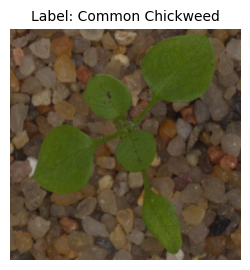

In [57]:
# Choix aléatoire d'une image du jeu de données et affichage

idx = np.random.randint(len(df))
print("Index de l'image à prédire:", idx,"\n")
filepath = df['filepath'][idx]

show_image(filepath)

In [58]:
# Affichage des prédictions par modèle

show_model_pred(filepath)
print("\n")
show_model_pred(filepath,model='ResNet50')
print("\n")
show_model_pred(filepath,model='VGG19')

Modèle MobileNetV2:


,Classe,Probabilité
1,Common Chickweed,100.00%
2,Shepherd's Purse,0.00%
3,Fat Hen,0.00%




Modèle ResNet50:


,Classe,Probabilité
1,Common Chickweed,100.00%
2,Shepherd's Purse,0.00%
3,Fat Hen,0.00%




Modèle VGG19:


,Classe,Probabilité
1,Common Chickweed,99.85%
2,Shepherd's Purse,0.11%
3,Small-flowered Cranesbill,0.02%


In [59]:
# Comparaison des prédictions des 3 modèles

show_model_pred(filepath,model='all')


Classe Probabilité
VGG19       1           Common Chickweed      99.85%
            2           Shepherd's Purse       0.11%
            3  Small-flowered Cranesbill       0.02%
MobileNetV2 1           Common Chickweed     100.00%
            2           Shepherd's Purse       0.00%
            3                    Fat Hen       0.00%
ResNet50    1           Common Chickweed     100.00%
            2           Shepherd's Purse       0.00%
            3                    Fat Hen       0.00%

#### 2. Prédiction sur une image externe

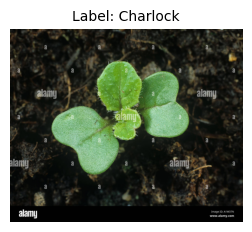

In [60]:
# Affichage de l'image

filepath = Path("External data","Charlock.jpg")

show_image(filepath,ext=True,label='Charlock')

In [61]:
# Affichage des prédictions des différents modèles

show_model_pred(filepath)
print("\n")
show_model_pred(filepath,model='ResNet50')
print("\n")
show_model_pred(filepath,model='VGG19')

Modèle MobileNetV2:


,Classe,Probabilité
1,Charlock,99.34%
2,Fat Hen,0.22%
3,Maize,0.21%




Modèle ResNet50:


,Classe,Probabilité
1,Charlock,50.11%
2,Scentless Mayweed,21.36%
3,Cleavers,9.69%




Modèle VGG19:


,Classe,Probabilité
1,Fat Hen,100.00%
2,Small-flowered Cranesbill,0.00%
3,Cleavers,0.00%


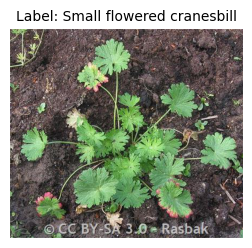

In [62]:
# Affichage de l'image

filepath = Path("External data","small_flower_cranesbill.jpg")

show_image(filepath,ext=True,label="Small flowered cranesbill")

In [63]:
# Affichage des prédictions des différents modèles

show_model_pred(filepath)
print("\n")
show_model_pred(filepath,model='ResNet50')
print("\n")
show_model_pred(filepath,model='VGG19')

Modèle MobileNetV2:


,Classe,Probabilité
1,Common wheat,89.09%
2,Maize,5.08%
3,Small-flowered Cranesbill,1.39%




Modèle ResNet50:


,Classe,Probabilité
1,Scentless Mayweed,99.81%
2,Shepherd's Purse,0.09%
3,Sugar beet,0.05%




Modèle VGG19:


,Classe,Probabilité
1,Charlock,100.00%
2,Shepherd's Purse,0.00%
3,Cleavers,0.00%


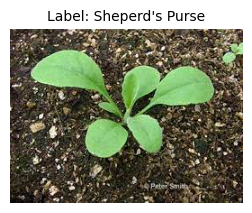

In [64]:
# Affichage de l'image

filepath = Path("External data","sheperds_purse.jpg")

show_image(filepath,ext=True,label="Sheperd's Purse")

In [65]:
# Affichage des prédictions des différents modèles

show_model_pred(filepath)
print("\n")
show_model_pred(filepath,model='ResNet50')
print("\n")
show_model_pred(filepath,model='VGG19')

Modèle MobileNetV2:


,Classe,Probabilité
1,Common wheat,51.08%
2,Black-grass,41.89%
3,Loose Silky-bent,2.60%




Modèle ResNet50:


,Classe,Probabilité
1,Scentless Mayweed,84.10%
2,Loose Silky-bent,8.58%
3,Black-grass,3.60%




Modèle VGG19:


,Classe,Probabilité
1,Charlock,100.00%
2,Fat Hen,0.00%
3,Shepherd's Purse,0.00%
